# Accelerating pipelines
-----------------------

This example shows how to accelerate your sklearn models on cpu.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Run the pipeline

In [3]:
atom = ATOMClassifier(X, "RainTomorrow", verbose=2)

<< ================== ATOM ================== >>
Algorithm task: binary classification.

Dataset stats ==================== >>
Shape: (142193, 22)
Memory: 61.69 MB
Scaled: False
Missing values: 316559 (10.1%)
Categorical features: 5 (23.8%)
Duplicate samples: 45 (0.0%)
-------------------------------------
Train set size: 113755
Test set size: 28438
-------------------------------------
|   |        dataset |          train |           test |
| - | -------------- | -------------- | -------------- |
| 0 |   110316 (3.5) |    88253 (3.5) |    22063 (3.5) |
| 1 |    31877 (1.0) |    25502 (1.0) |     6375 (1.0) |



In [4]:
# Impute missing values and encode categorical columns
atom.impute()
atom.encode()

Fitting Imputer...
Imputing missing values...
 --> Dropping 637 samples due to missing values in feature MinTemp.
 --> Dropping 322 samples due to missing values in feature MaxTemp.
 --> Dropping 1406 samples due to missing values in feature Rainfall.
 --> Dropping 60843 samples due to missing values in feature Evaporation.
 --> Dropping 67816 samples due to missing values in feature Sunshine.
 --> Dropping 9330 samples due to missing values in feature WindGustDir.
 --> Dropping 9270 samples due to missing values in feature WindGustSpeed.
 --> Dropping 10013 samples due to missing values in feature WindDir9am.
 --> Dropping 3778 samples due to missing values in feature WindDir3pm.
 --> Dropping 1348 samples due to missing values in feature WindSpeed9am.
 --> Dropping 2630 samples due to missing values in feature WindSpeed3pm.
 --> Dropping 1774 samples due to missing values in feature Humidity9am.
 --> Dropping 3610 samples due to missing values in feature Humidity3pm.
 --> Dropping 14

In [5]:
# Train a Random Forest model (using default sklearn)
atom.run(models="KNN", metric="f1")


Training ========================= >>
Models: KNN
Metric: f1


Results for K-Nearest Neighbors:
Fit ---------------------------------------------
Train evaluation --> f1: 0.7107
Test evaluation --> f1: 0.6032
Time elapsed: 1.373s
-------------------------------------------------
Total time: 1.374s


Final results ==================== >>
Total time: 1.375s
-------------------------------------
K-Nearest Neighbors --> f1: 0.6032


In [6]:
# Now, we train an accelerated Random Forest using engine="sklearnex"
# Note the diffrence in training speed!!
atom.run(models="KNN_acc", metric="f1", engine="sklearnex")


Training ========================= >>
Models: KNN_acc
Metric: f1


Results for K-Nearest Neighbors:
Fit ---------------------------------------------
Train evaluation --> f1: 0.7107
Test evaluation --> f1: 0.6032
Time elapsed: 0.803s
-------------------------------------------------
Total time: 0.803s


Final results ==================== >>
Total time: 0.804s
-------------------------------------
K-Nearest Neighbors --> f1: 0.6032


## Analyze the results

In [7]:
atom.results

,score_train,score_test,time_fit,time
KNN,0.710663,0.603153,1.373249,1.374250
KNN_acc,0.710663,0.603153,0.802732,0.802732


In [8]:
# Note how the underlying estimators might look the same...
print(atom.knn.estimator)
print(atom.knn_acc.estimator)

# ... but are using different implementations
print(atom.knn.estimator.__module__)
print(atom.knn_acc.estimator.__module__)

KNeighborsClassifier(n_jobs=1)
KNeighborsClassifier(n_jobs=1)
sklearn.neighbors._classification
sklearnex.neighbors.knn_classification


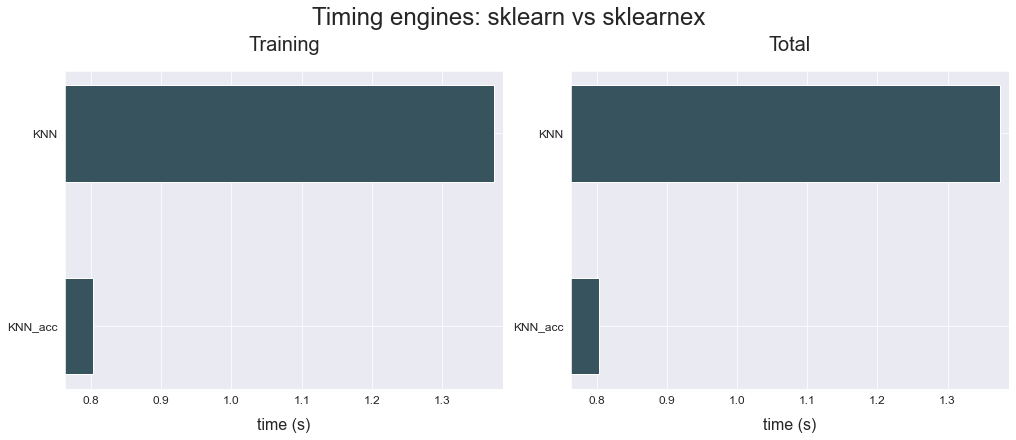

In [9]:
with atom.canvas(1, 2, title="Timing engines: sklearn vs sklearnex"):
    atom.plot_results(metric="time_fit", title="Training")
    atom.plot_results(metric="time", title="Total")